# Customer Segmentation Using K-means Clustering

## Objective
Segment customers based on:
- **Average Rating:** The mean rating a customer has given across all their reviews.
- **Review Frequency:** The total number of reviews written by a customer.

This segmentation can help identify:
- **Loyal Customers:** High average ratings and frequent reviews.
- **Critical Customers:** Low average ratings and few reviews.
- **Neutral Customers:** Moderate ratings and review frequency.

## Step 1: Data Preparation
Aggregate the dataset by `user_id` to compute the average rating and review frequency.

*Assumption:* The dataset (e.g., `amazon_sales.csv`) contains columns like `user_id`, `rating`, and `review_id` (or `product_id` for counting reviews).



In [2]:
import pandas as pd

# Load the dataset
df = pd.read_csv('../data/amazon_sales.csv')

In [4]:
# Clean and convert columns by first converting to string
df['discounted_price'] = df['discounted_price'].astype(str).str.replace('[₹,]', '', regex=True).astype(float)
df['actual_price'] = df['actual_price'].astype(str).str.replace('[₹,]', '', regex=True).astype(float)
df['discount_percentage'] = df['discount_percentage'].astype(str).str.replace('%', '', regex=False).astype(float) / 100

# Convert 'rating' to numeric; non-numeric values will become NaN
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')

# For 'rating_count', first convert to string then remove commas and convert to numeric
df['rating_count'] = pd.to_numeric(df['rating_count'].astype(str).str.replace(',', '', regex=False), errors='coerce')

# Handle missing values by using assignment rather than inplace to avoid chained assignment warnings
df['rating'] = df['rating'].fillna(df['rating'].median())
df['rating_count'] = df['rating_count'].fillna(0)



In [5]:


# Aggregate data by user_id
user_data = df.groupby('user_id').agg(
    avg_rating=('rating', 'mean'),
    review_frequency=('review_id', 'count')  # Count of reviews per user
).reset_index()

In [6]:
from sklearn.preprocessing import StandardScaler

# Select features for clustering
features = user_data[['avg_rating', 'review_frequency']]

# Standardize the features (mean=0, std=1)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)


## Step 3: Determine the Optimal Number of Clusters

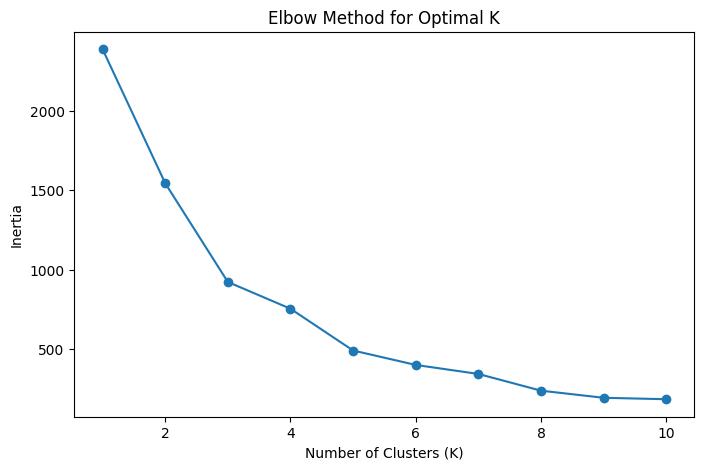

In [7]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Calculate inertia for K values from 1 to 10
inertia = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.show()


## Step 4: Apply K-means Clustering

In [8]:
# Apply K-means with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
user_data['cluster'] = kmeans.fit_predict(scaled_features)


## Step 5: Analyze the Clusters

In [11]:
# Step 5: Add Interpretation Column
interpretation_mapping = {
    0: 'Loyal Customers',   # High ratings and frequent reviews
    1: 'Critical Customers',# Low ratings and few reviews
    2: 'Neutral Customers'  # Moderate ratings and review frequency
}
user_data['interpretation'] = user_data['cluster'].map(interpretation_mapping)

In [13]:
# Summarize cluster characteristics (including interpretation)
cluster_summary = user_data.groupby('cluster').agg(
    avg_rating=('avg_rating', 'mean'),
    avg_review_frequency=('review_frequency', 'mean')
).reset_index()

# Add interpretation to the summary based on the mapping
cluster_summary['interpretation'] = cluster_summary['cluster'].map(interpretation_mapping)

print("Cluster Summary with Interpretation:")
print(cluster_summary)


Cluster Summary with Interpretation:
   cluster  avg_rating  avg_review_frequency      interpretation
0        0    3.869458              1.037767     Loyal Customers
1        1    4.329070              1.100775  Critical Customers
2        2    4.155072              3.840580   Neutral Customers


## Step 6: Visualize the Results

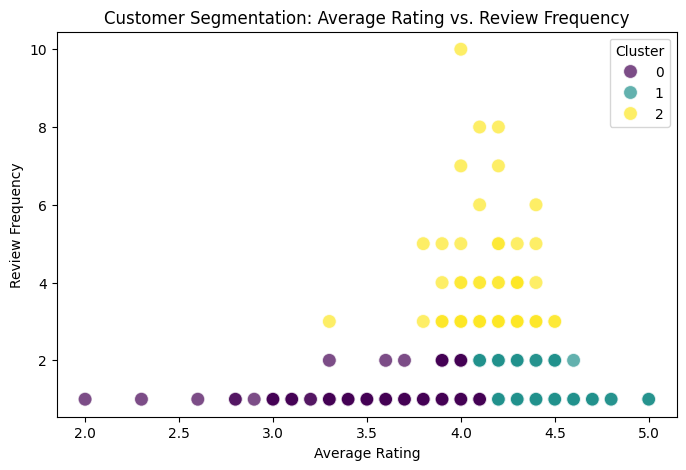

In [14]:
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.scatterplot(
    x='avg_rating', y='review_frequency', hue='cluster', 
    data=user_data, palette='viridis', s=100, alpha=0.7
)
plt.title('Customer Segmentation: Average Rating vs. Review Frequency')
plt.xlabel('Average Rating')
plt.ylabel('Review Frequency')
plt.legend(title='Cluster')
plt.show()
